In [109]:
import warnings
warnings.filterwarnings('ignore')
from sklearn import neighbors, model_selection, metrics
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
from sklearn import tree
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LinearRegression
import statistics
import graphviz
from subprocess import check_call
import os
from sklearn.feature_selection import VarianceThreshold
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, classification_report
import matplotlib.patches as mpatches
from pylab import rcParams
from sklearn.cluster import KMeans  
import matplotlib.pyplot as plt  
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import MinMaxScaler

import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline
rcParams['figure.figsize'] = 10, 7

In [110]:
def fill_missing_values(dataset, feature_names, class_name):
    dataset_preprocessed = dataset.copy()
    
    if class_name == "oi":
        for feature in feature_names:
            dataset_preprocessed[feature] = dataset_preprocessed.transform(lambda x: x.fillna(x.mean()))[feature]
    else:
        for feature in feature_names:
            dataset_preprocessed[feature] = dataset_preprocessed.groupby(class_name).transform(lambda x: x.fillna(x.mean()))[feature]

    return dataset_preprocessed

Load dataset 1 -- TRAIN

In [111]:
green_ds = pd.read_csv("datasets/second/green.csv")
hinselmann_ds = pd.read_csv("datasets/second/hinselmann.csv")
schiller_ds = pd.read_csv("datasets/second/schiller.csv")

green_ds["green_ds"] = 1
green_ds["hinselmann_ds"] = 0
green_ds["schiller_ds"] = 0

hinselmann_ds["green_ds"] = 0
hinselmann_ds["hinselmann_ds"] = 1
hinselmann_ds["schiller_ds"] = 0

schiller_ds["green_ds"] = 0
schiller_ds["hinselmann_ds"] = 0
schiller_ds["schiller_ds"] = 1

aps_train = pd.concat([green_ds,hinselmann_ds,schiller_ds])

class_attributes = ["consensus","experts::0","experts::1","experts::2","experts::3","experts::4","experts::5",]

X = aps_train.drop(labels = class_attributes, axis = "columns")
feature_names = X.columns.tolist()
print(feature_names)
Y = aps_train[class_attributes[0]].values

['cervix_area', 'os_area', 'walls_area', 'speculum_area', 'artifacts_area', 'cervix_artifacts_area', 'os_artifacts_area', 'walls_artifacts_area', 'speculum_artifacts_area', 'cervix_specularities_area', 'os_specularities_area', 'walls_specularities_area', 'speculum_specularities_area', 'specularities_area', 'area_h_max_diff', 'rgb_cervix_r_mean', 'rgb_cervix_r_std', 'rgb_cervix_r_mean_minus_std', 'rgb_cervix_r_mean_plus_std', 'rgb_cervix_g_mean', 'rgb_cervix_g_std', 'rgb_cervix_g_mean_minus_std', 'rgb_cervix_g_mean_plus_std', 'rgb_cervix_b_mean', 'rgb_cervix_b_std', 'rgb_cervix_b_mean_minus_std', 'rgb_cervix_b_mean_plus_std', 'rgb_total_r_mean', 'rgb_total_r_std', 'rgb_total_r_mean_minus_std', 'rgb_total_r_mean_plus_std', 'rgb_total_g_mean', 'rgb_total_g_std', 'rgb_total_g_mean_minus_std', 'rgb_total_g_mean_plus_std', 'rgb_total_b_mean', 'rgb_total_b_std', 'rgb_total_b_mean_minus_std', 'rgb_total_b_mean_plus_std', 'hsv_cervix_h_mean', 'hsv_cervix_h_std', 'hsv_cervix_s_mean', 'hsv_cervix

Pre-processing 1

In [112]:
scaler = MinMaxScaler(feature_range=[0, 1])
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data=X_scaled, columns = feature_names)
X_scaled.insert(0, "class", Y)
X_preproc_1 = X_scaled.iloc[:,1:]
Y_preproc_1 = X_scaled['class']
X_preproc_1.shape

(287, 65)

# K-means -- Future work: aplicar a test (pre-proc?) tambem, grafico com 2 curvas

In [113]:
ns = range(1,21)
inertias, inertias_pre1 = [], []
mse, mse_pre1 = [], []
for n in ns:
    print(n)
    kmeans = KMeans(n_clusters=n).fit(X)
    kmeans_pre1 = KMeans(n_clusters=n).fit(X_preproc_1)
    
    inertias.append(kmeans.inertia_)
    inertias_pre1.append(kmeans_pre1.inertia_)
    
    y_labels = Y.reshape((-1,))
    mse.append(metrics.mean_squared_error(y_labels, kmeans.labels_))
    mse_pre1.append(metrics.mean_squared_error(y_labels, kmeans_pre1.labels_))
    
print("Inertias baseline: ", inertias)
print("Inertias pre-proc1: ", inertias_pre1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Inertias baseline:  [19727186.019926112, 13424600.671968065, 10270884.174952699, 8684145.617990058, 7652353.344578819, 6559238.000497488, 5872917.298738293, 5440375.966627365, 5147622.332622545, 4732635.4910167, 4491621.001750652, 4328165.167563646, 4093466.9611003776, 3971731.871193552, 3855926.781640548, 3712393.2502758317, 3562748.761885656, 3489556.576070369, 3349041.9180954415, 3277228.414432063]
Inertias pre-proc1:  [956.9059016446852, 707.438277206878, 547.7805573063641, 472.163010170607, 404.246139201849, 358.911478786308, 322.607108232817, 302.4038403053232, 287.2088606907338, 274.1925483370225, 266.39943878745356, 259.42199958938073, 253.96157033563526, 249.31691848602395, 239.0487703220067, 232.56696424717643, 228.4049266712474, 226.3816292688374, 217.91917018353413, 214.00934213437262]


In [25]:
print("MSE baseline: ", mse)
print("MSE pre-proc1: ", mse_pre1)

MSE baseline:  [0.7526132404181185, 0.5958188153310104, 0.7874564459930313, 1.9337979094076656, 3.926829268292683, 4.97212543554007, 7.073170731707317, 13.174216027874564, 20.285714285714285, 19.585365853658537, 30.153310104529616, 29.048780487804876, 40.613240418118465, 42.10452961672474, 54.37979094076655, 79.62717770034843, 67.60975609756098, 75.2369337979094, 102.26829268292683, 75.25435540069687]
MSE pre-proc1:  [0.7526132404181185, 0.3693379790940767, 0.8362369337979094, 1.0627177700348431, 3.4355400696864113, 6.609756097560975, 9.829268292682928, 13.146341463414634, 12.059233449477352, 23.45296167247387, 27.885017421602786, 27.67595818815331, 31.72822299651568, 41.43205574912892, 52.67595818815331, 66.23344947735191, 71.74216027874564, 81.07665505226481, 88.8048780487805, 85.41811846689896]


In [49]:
ns = range(2,21)
silhouettes, silhouettes_pre1, silhouettes_pre2, silhouettes_pre3, silhouettes_test = [], [], [], [], []
for n in ns:
    kmeans = KMeans(n_clusters=n).fit(X)
    kmeans_pre1 = KMeans(n_clusters=n).fit(X_preproc_1)
    
    silhouettes.append(metrics.silhouette_score(X, kmeans.labels_, metric='euclidean'))
    silhouettes_pre1.append(metrics.silhouette_score(X_preproc_1, kmeans_pre1.labels_, metric='euclidean'))
    
print("Silhouettes baseline: ", silhouettes)
print("Silhouettes pre-proc1: ", silhouettes_pre1)

Silhouettes baseline:  [0.30524767031390226, 0.3172678592369222, 0.28402500749274034, 0.297630101957045, 0.2876849544583181, 0.2964358492294414, 0.28732072243711, 0.25834964647313396, 0.26464297890480604, 0.25831290591622924, 0.26979993702465277, 0.26171812678714934, 0.24861480357191637, 0.25696655009440256, 0.2518539707736784, 0.22834836654508636, 0.2601481720764804, 0.23468354885623985, 0.21911282318381223]
Silhouettes pre-proc1:  [0.27742509622059475, 0.3063494924389024, 0.327201940555607, 0.304749345009288, 0.3034445350571053, 0.27062824802514657, 0.24980509452873534, 0.23493519277672387, 0.20836664852917844, 0.20136543157132533, 0.1915297944794529, 0.18602976390301348, 0.18987556357399096, 0.17209575268199015, 0.1481578502296426, 0.16219135297853837, 0.15129897390456815, 0.16462707670402177, 0.14553186221629913]


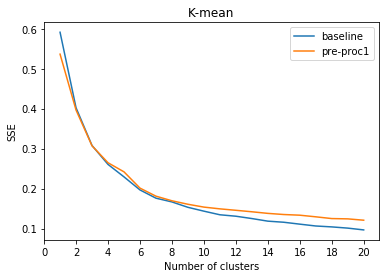

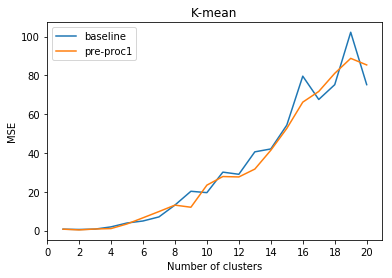

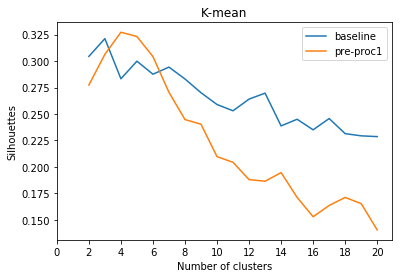

In [48]:
ns = range(1,21)

inertias_norm = inertias / np.linalg.norm(inertias)
inertias_pre1_norm = inertias_pre1 / np.linalg.norm(inertias_pre1)

plt.figure()
plt.plot(ns,inertias_norm,label="baseline")
plt.plot(ns,inertias_pre1_norm, label="pre-proc1")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("K-mean")
plt.xticks(np.arange(0, 21, step=2))
plt.legend()
plt.show()

plt.figure()
plt.plot(ns,mse,label="baseline")
plt.plot(ns,mse_pre1, label="pre-proc1")
plt.xticks(np.arange(0, 21, step=2))
plt.xlabel("Number of clusters")
plt.ylabel("MSE")
plt.title("K-mean")
plt.legend()
plt.show()


plt.figure()
plt.plot(ns[1:],silhouettes,label="baseline")
plt.plot(ns[1:],silhouettes_pre1, label="pre-proc1")
plt.xticks(np.arange(0, 21, step=2))
plt.xlabel("Number of clusters")
plt.ylabel("Silhouettes")
plt.title("K-mean")
plt.legend()
plt.show()

# PCA + K-means 

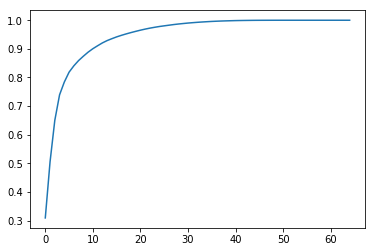

In [50]:
pca_pre1 = sklearnPCA().fit(X_preproc_1)
plt.plot(np.cumsum(pca_pre1.explained_variance_ratio_))
plt.show()

In [51]:
pca = sklearnPCA(n_components=35)
Y_pca = pca.fit_transform(X)
Y_pca_pre1 = pca.fit_transform(X_preproc_1)

inertias_pca, inertias_pre1_pca = [], []
ns = range(1,21)
for n in ns:
    kmeans = KMeans(n_clusters=n).fit(Y_pca)
    kmeans_pre1 = KMeans(n_clusters=n).fit(Y_pca_pre1)
    
    inertias_pca.append(kmeans.inertia_)
    inertias_pre1_pca.append(kmeans_pre1.inertia_)
    
print("Inertias baseline PCA: ", inertias_pca)
print("Inertias pre-proc1 PCA: ", inertias_pre1_pca)

Inertias baseline PCA:  [19727178.021056473, 13424592.681586495, 10270876.190800877, 8680576.510697046, 7563991.400829472, 6559230.044875041, 5861758.810020739, 5470183.721328629, 5066126.666882572, 4735910.382599889, 4560476.442144589, 4319731.908568078, 4093607.774975326, 3967646.62330251, 3850776.1521001714, 3677256.211400681, 3636309.53389722, 3432451.6366054337, 3380905.5420326316, 3276977.073301702]
Inertias pre-proc1 PCA:  [952.0469438642524, 702.5796016096218, 542.9219261061538, 468.5380076549016, 395.71641531224617, 354.11429525693455, 317.93340928792924, 297.92680229090934, 282.5300593390181, 276.1767347239807, 263.0490145364235, 255.4214382513222, 247.57166028869176, 243.74435182869553, 234.5191483458426, 231.58921961436621, 223.45628767329086, 219.20333153566617, 216.35978650144474, 210.44334273751335]


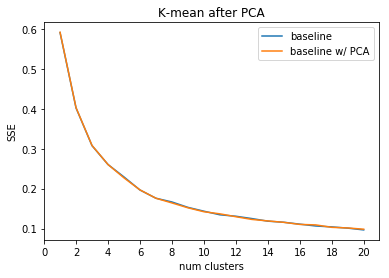

In [52]:
inertias_pca_norm = inertias_pca / np.linalg.norm(inertias_pca)
inertias_pre1_pca_norm = inertias_pre1_pca / np.linalg.norm(inertias_pre1_pca)

plt.plot(ns,inertias_norm,label="baseline")
#plt.plot(ns,inertias_pre1_norm, label="pre-proc1")
#plt.plot(ns,inertias_test_norm, label="test set")

plt.plot(ns,inertias_pca_norm,label="baseline w/ PCA")
#plt.plot(ns,inertias_pre1_pca_norm, label="pre-proc1 w/ PCA")
#plt.plot(ns,inertias_test_norm, label="test set")

plt.xlabel("num clusters")
plt.ylabel("SSE")
plt.title("K-mean after PCA")
plt.legend()
plt.xticks(np.arange(0, 21, step=2))
plt.show()

# DBSCAN  !!DANGER -- KERNEL MORRE

Rand Indexe:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
MSE:  [3.2578397212543555, 0.7526132404181185, 3.2578397212543555, 3.2578397212543555, 3.2578397212543555, 3.2578397212543555]
Mutual info:  [6.661338147750939e-16, 6.661338147750939e-16, 6.661338147750939e-16, 6.661338147750939e-16, 6.661338147750939e-16, 6.661338147750939e-16]


<function matplotlib.pyplot.show(*args, **kw)>

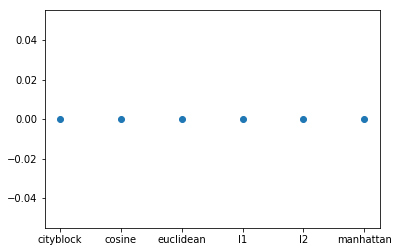

In [57]:
# ----- CHOOSE METRIC -----

ms = ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan"]
rand_indexes, mses, mutual_infos = [], [], []
for m in ms:
    db = DBSCAN(metric=m).fit(X)
    labels = db.labels_
    rand_indexes.append(metrics.adjusted_rand_score(Y.reshape((-1,)), labels))
    mses.append(metrics.mean_squared_error(Y.reshape((-1,)), labels))
    mutual_infos.append(metrics.mutual_info_score(Y.reshape((-1,)), labels))
print("Rand Indexe: ", rand_indexes)
print("MSE: ", mses)
print("Mutual info: ", mutual_infos)

plt.plot(ms,rand_indexes,'o')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

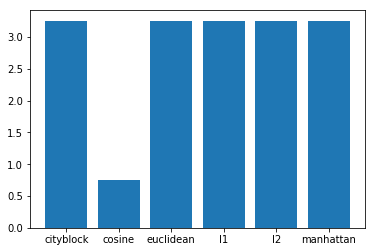

In [63]:
plt.bar(ms,mses)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

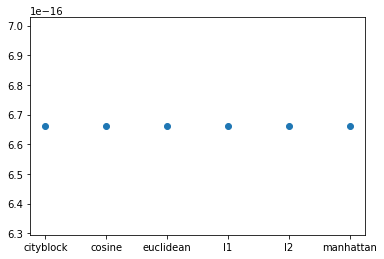

In [64]:
plt.plot(ms,mutual_infos,'o')
plt.show

In [94]:
ris, mses, infos, silhouettes = [], [], [], []

epss = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]
for e in epss:
    print(e)
    db = DBSCAN(eps=e,metric="cosine").fit(X)

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    ri = metrics.adjusted_rand_score(Y, labels)
    mse = metrics.mean_squared_error(Y, labels)
    info = metrics.mutual_info_score(Y, labels)
    sample = int(X.shape[0]*0.5)
    #silh = metrics.silhouette_score(X, labels, metric='euclidean',sample_size=sample)
    
    ris.append(ri)
    mses.append(mse)
    infos.append(info)
    silhouettes.append(silh)
    
    print("Adjusted Rand Index: %0.3f" % ri)
    print("MSE: %0.3f" % mse)
    print("Info Score :", info)
    print("silhouette_score: %0.3f" % silh)
    
print("Rand Indexes: ", ris)
print("MSEs: ", mses)
print("Info scores: ", infos)
print("Silhouette scores: ", silhouettes)

0.05
Adjusted Rand Index: 0.115
MSE: 0.829
Info Score : 0.02494428645522443
silhouette_score: 0.263
0.1
Adjusted Rand Index: 0.081
MSE: 0.808
Info Score : 0.016457299616666636
silhouette_score: 0.263
0.15
Adjusted Rand Index: 0.000
MSE: 0.753
Info Score : 6.661338147750939e-16
silhouette_score: 0.263
0.2
Adjusted Rand Index: 0.000
MSE: 0.753
Info Score : 6.661338147750939e-16
silhouette_score: 0.263
0.25
Adjusted Rand Index: 0.000
MSE: 0.753
Info Score : 6.661338147750939e-16
silhouette_score: 0.263
0.3
Adjusted Rand Index: 0.000
MSE: 0.753
Info Score : 6.661338147750939e-16
silhouette_score: 0.263
0.35
Adjusted Rand Index: 0.000
MSE: 0.753
Info Score : 6.661338147750939e-16
silhouette_score: 0.263
0.4
Adjusted Rand Index: 0.000
MSE: 0.753
Info Score : 6.661338147750939e-16
silhouette_score: 0.263
0.45
Adjusted Rand Index: 0.000
MSE: 0.753
Info Score : 6.661338147750939e-16
silhouette_score: 0.263
0.5
Adjusted Rand Index: 0.000
MSE: 0.753
Info Score : 6.661338147750939e-16
silhouette_s

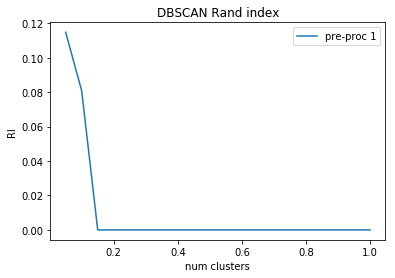

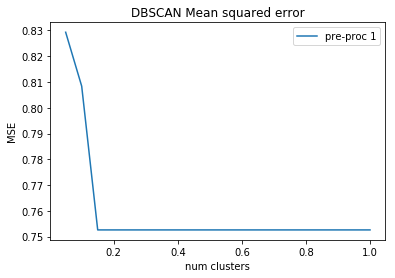

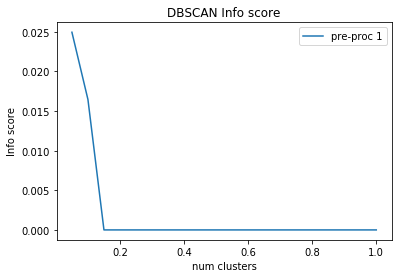

In [95]:
#plt.plot(ns,inertias_norm,label="baseline")

plt.plot(epss,ris,label="pre-proc 1")
plt.xlabel("num clusters")
plt.ylabel("RI")
plt.title("DBSCAN Rand index")
plt.legend()
plt.show()

plt.plot(epss,mses,label="pre-proc 1")
plt.xlabel("num clusters")
plt.ylabel("MSE")
plt.title("DBSCAN Mean squared error")
plt.legend()
plt.show()

plt.plot(epss,infos,label="pre-proc 1")
plt.xlabel("num clusters")
plt.ylabel("Info score")
plt.title("DBSCAN Info score")
plt.legend()
plt.show()

In [104]:
# create kmeans object
kmeans = KMeans(n_clusters=4)

# fit kmeans object to data
kmeans.fit(X)

# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)

# save new clusters for chart
y_km = kmeans.fit_predict(X)

[[4.68645732e-01 8.25126451e-03 1.55512977e-01 2.57368589e-01
  5.65224640e-02 4.38734721e-02 7.28490833e-02 3.49469008e-02
  2.60096225e-02 2.44872469e-02 2.27177074e-02 1.01976407e-02
  7.98295409e-02 3.29746675e-02 2.05588301e-01 1.14481741e+02
  4.33539928e+01 7.11277484e+01 1.57835734e+02 8.26600833e+01
  3.45431660e+01 4.81169173e+01 1.17203249e+02 1.70579815e+02
  5.44454539e+01 1.16134361e+02 2.25025269e+02 9.69737883e+01
  5.48940707e+01 4.20797177e+01 1.51867859e+02 7.28653917e+01
  4.46344993e+01 2.82308925e+01 1.17499891e+02 1.32823324e+02
  6.89026532e+01 6.39206703e+01 2.01725977e+02 4.37451836e+00
  2.91774200e+00 1.33317667e+02 3.02577649e+01 1.71245769e+02
  5.43934634e+01 4.24819083e+00 2.69748463e+00 1.17594098e+02
  4.00370252e+01 1.36774152e+02 6.81495919e+01 9.43945611e-01
  4.92217193e-01 8.06815138e-01 5.71842500e-01 6.07625200e-01
  7.77917741e-01 9.69356970e-01 4.78511937e-01 1.31280817e+02
  4.76597276e-01 4.01779685e-01 2.77555756e-16 8.53211009e-01
  1.4678

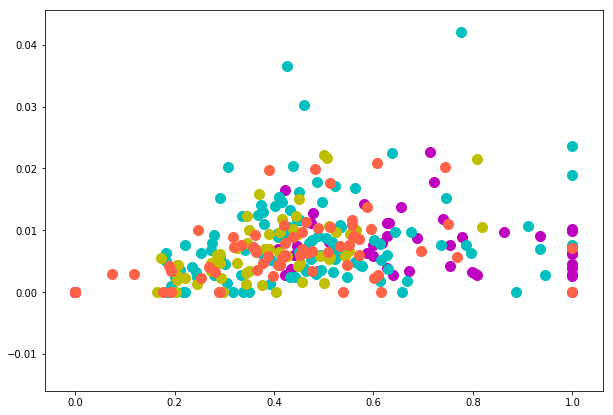

In [105]:
plt.scatter(X.iloc[y_km ==0,0], X.iloc[y_km == 0,1], s=100, c='m')
plt.scatter(X.iloc[y_km ==1,0], X.iloc[y_km == 1,1], s=100, c='c')
plt.scatter(X.iloc[y_km ==2,0], X.iloc[y_km == 2,1], s=100, c='y')
plt.scatter(X.iloc[y_km ==3,0], X.iloc[y_km == 3,1], s=100, c='tomato')

# hierarchichal

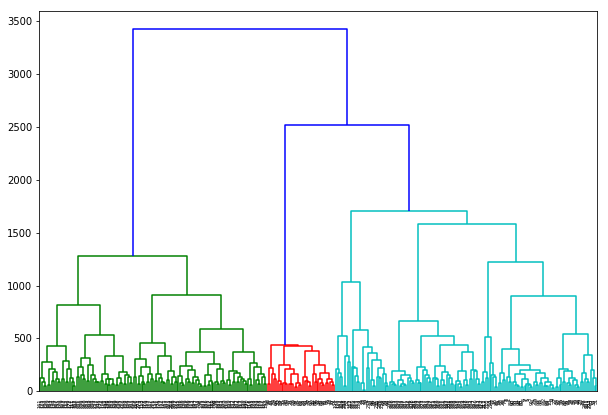

In [108]:
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')

# save clusters for chart
y_hc = hc.fit_predict(X)

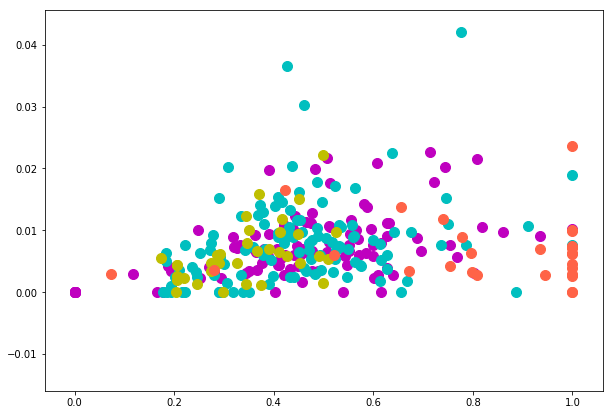

In [103]:
plt.scatter(X.iloc[y_hc ==0,0], X.iloc[y_hc == 0,1], s=100, c='m')
plt.scatter(X.iloc[y_hc==1,0], X.iloc[y_hc == 1,1], s=100, c='c')
plt.scatter(X.iloc[y_hc ==2,0], X.iloc[y_hc == 2,1], s=100, c='y')
plt.scatter(X.iloc[y_hc ==3,0], X.iloc[y_hc == 3,1], s=100, c='tomato')